In [1]:
#imports
%matplotlib notebook
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam

#generating approximately linear data from python func
from lin_reg_data import getLinRegDatasets

In [2]:
# training parameters

num_epochs = 5
batch_size = 32

lr = 0.001
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Mon Sep 20 17:55:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 32%   46C    P2    38W / 250W |   7448MiB / 12066MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:1'

In [5]:
#init datasets and dataloaders

#setting data parameters
num_train = 5000
num_test = 100
y_dim = 1
x_dim = 1
m_var = 0.25
b_var = 0.25

#setting random number seed for data generation
np.random.seed(seed=0)

train_set, test_set, m, b = getLinRegDatasets(num_train, num_test,
                                            x_dim=x_dim, y_dim=y_dim,
                                            m_var=m_var, b_var=b_var)

train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = nn.Linear(x_dim, y_dim)
        self.param_updates = 0

    def forward(self, x):
        return self.lin(x)
    
loss_fn = nn.MSELoss()
model = Model()
model.to(device)

Model(
  (lin): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)

#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
ep_train_loss = np.zeros((num_epochs+1))
test_loss = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin.weight size: 1
lin.bias size: 1
Total num. parameters: 2
param states shape: (786, 2)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader)
    
    total_loss = 0.0

    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()
        
        print(grad)

        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()
        total_loss += loss.item()

        model.param_updates += 1

    return total_loss/size

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_minibatches
    return test_loss

In [9]:
model.param_updates=0

#Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)

#Getting initial train and test loss
train_loss[0] = test(train_data, model, loss_fn)
ep_train_loss[0] = test(train_data, model, loss_fn)  
test_loss[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    #Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.9, drop_rate=1)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=1)

    ep_train_loss[j+1] = train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    test_loss[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
[array([[-0.32559147]], dtype=float32), array([-0.51474345], dtype=float32)]
[array([[-0.37239698]], dtype=float32), array([-0.5450182], dtype=float32)]
[array([[-0.28205073]], dtype=float32), array([-0.42430615], dtype=float32)]
[array([[-0.24030331]], dtype=float32), array([-0.4472816], dtype=float32)]
[array([[-0.23195074]], dtype=float32), array([-0.416435], dtype=float32)]
[array([[-0.15547378]], dtype=float32), array([-0.31656528], dtype=float32)]
[array([[-0.22683966]], dtype=float32), array([-0.4278911], dtype=float32)]
[array([[-0.38239515]], dtype=float32), array([-0.6007441], dtype=float32)]
[array([[-0.26604939]], dtype=float32), array([-0.40788585], dtype=float32)]
[array([[-0.21141602]], dtype=float32), array([-0.37356165], dtype=float32)]
[array([[-0.30451077]], dtype=float32), array([-0.49600247], dtype=float32)]
[array([[-0.31523114]], dtype=float32), array([-0.46685275], dtype=float32)]
[array([[-0.30118886]], dtype=float32), array([-0.54007155], dtype=flo

[array([[-0.16642463]], dtype=float32), array([-0.19988629], dtype=float32)]
[array([[-0.16239461]], dtype=float32), array([-0.26124725], dtype=float32)]
[array([[-0.15194458]], dtype=float32), array([-0.22260147], dtype=float32)]
[array([[-0.08115312]], dtype=float32), array([-0.14994079], dtype=float32)]
[array([[-0.13318376]], dtype=float32), array([-0.23609361], dtype=float32)]
[array([[-0.08777207]], dtype=float32), array([-0.1563715], dtype=float32)]
[array([[-0.1995179]], dtype=float32), array([-0.31022984], dtype=float32)]
[array([[-0.16422991]], dtype=float32), array([-0.21201226], dtype=float32)]
[array([[-0.23406689]], dtype=float32), array([-0.34524995], dtype=float32)]
[array([[-0.04922581]], dtype=float32), array([-0.05418502], dtype=float32)]
[array([[-0.13463977]], dtype=float32), array([-0.25252634], dtype=float32)]
[array([[-0.18258175]], dtype=float32), array([-0.29079348], dtype=float32)]
[array([[-0.1065466]], dtype=float32), array([-0.09749788], dtype=float32)]
[a

[array([[-0.11977641]], dtype=float32), array([-0.14002898], dtype=float32)]
[array([[-0.14279798]], dtype=float32), array([-0.13127056], dtype=float32)]
[array([[-0.04979573]], dtype=float32), array([-0.04341821], dtype=float32)]
[array([[-0.04062447]], dtype=float32), array([-0.04413673], dtype=float32)]
[array([[-0.02127272]], dtype=float32), array([-0.02697634], dtype=float32)]
[array([[-0.00940787]], dtype=float32), array([0.00975676], dtype=float32)]
[array([[-0.15428323]], dtype=float32), array([-0.20389211], dtype=float32)]
[array([[-0.04110617]], dtype=float32), array([0.00673776], dtype=float32)]
[array([[-0.01886432]], dtype=float32), array([-0.01709446], dtype=float32)]
[array([[0.01936525]], dtype=float32), array([0.10624773], dtype=float32)]
[array([[-0.05405942]], dtype=float32), array([-0.00176022], dtype=float32)]
[array([[-0.05885765]], dtype=float32), array([-0.05577274], dtype=float32)]
[array([[-0.05252779]], dtype=float32), array([-0.0846466], dtype=float32)]
[arr

[array([[-0.06420954]], dtype=float32), array([-0.03971314], dtype=float32)]
[array([[0.03611713]], dtype=float32), array([0.08321813], dtype=float32)]
[array([[-0.03844608]], dtype=float32), array([-0.04388702], dtype=float32)]
[array([[-0.08470081]], dtype=float32), array([-0.11505058], dtype=float32)]
[array([[0.00256979]], dtype=float32), array([0.06637149], dtype=float32)]
[array([[-0.02673654]], dtype=float32), array([-0.02473197], dtype=float32)]
[array([[-0.04617872]], dtype=float32), array([-0.04052483], dtype=float32)]
[array([[-0.08323719]], dtype=float32), array([-0.04878251], dtype=float32)]
[array([[-0.06291865]], dtype=float32), array([-0.03765002], dtype=float32)]
[array([[-0.02508564]], dtype=float32), array([-0.03070849], dtype=float32)]
[array([[0.02536047]], dtype=float32), array([0.06460632], dtype=float32)]
[array([[-0.02123131]], dtype=float32), array([-0.01089146], dtype=float32)]
[array([[0.01848302]], dtype=float32), array([0.10585555], dtype=float32)]
[array(

 - Epoch: 4
[array([[-0.00880089]], dtype=float32), array([0.06668636], dtype=float32)]
[array([[-0.00996705]], dtype=float32), array([0.02208141], dtype=float32)]
[array([[-0.10238546]], dtype=float32), array([-0.13579156], dtype=float32)]
[array([[0.00119722]], dtype=float32), array([0.03949335], dtype=float32)]
[array([[-0.02418586]], dtype=float32), array([0.01159621], dtype=float32)]
[array([[0.02572355]], dtype=float32), array([0.07443465], dtype=float32)]
[array([[0.00095505]], dtype=float32), array([0.03130763], dtype=float32)]
[array([[-0.04293233]], dtype=float32), array([-0.00913958], dtype=float32)]
[array([[-0.00349493]], dtype=float32), array([0.01241783], dtype=float32)]
[array([[-0.02679433]], dtype=float32), array([-0.00873922], dtype=float32)]
[array([[-0.00219222]], dtype=float32), array([0.04921673], dtype=float32)]
[array([[0.0048894]], dtype=float32), array([0.01857373], dtype=float32)]
[array([[0.06702217]], dtype=float32), array([0.14273025], dtype=float32)]
[ar

[array([[0.04797971]], dtype=float32), array([0.20831525], dtype=float32)]
[array([[-0.07578078]], dtype=float32), array([-0.0944093], dtype=float32)]
[array([[-0.00709397]], dtype=float32), array([-0.01936231], dtype=float32)]
[array([[-0.00734285]], dtype=float32), array([0.03262748], dtype=float32)]
[array([[0.00912649]], dtype=float32), array([0.00450708], dtype=float32)]
[array([[-0.01709183]], dtype=float32), array([0.01051871], dtype=float32)]
[array([[-0.02703504]], dtype=float32), array([-0.0217263], dtype=float32)]
[array([[0.03861991]], dtype=float32), array([0.10207175], dtype=float32)]
[array([[0.0171207]], dtype=float32), array([0.03568308], dtype=float32)]
[array([[0.00180566]], dtype=float32), array([0.07212228], dtype=float32)]
[array([[0.00427857]], dtype=float32), array([0.00136655], dtype=float32)]
[array([[-0.10085645]], dtype=float32), array([-0.11211742], dtype=float32)]
[array([[0.00128508]], dtype=float32), array([0.03208199], dtype=float32)]
[array([[-0.046039

[array([[-0.02565213]], dtype=float32), array([0.00050783], dtype=float32)]
[array([[0.03180309]], dtype=float32), array([0.06380923], dtype=float32)]
[array([[-0.03312288]], dtype=float32), array([-0.0654756], dtype=float32)]
[array([[-0.02458853]], dtype=float32), array([-0.03374713], dtype=float32)]
[array([[0.01203339]], dtype=float32), array([0.04101395], dtype=float32)]
[array([[-0.02623574]], dtype=float32), array([-0.01492834], dtype=float32)]
[array([[0.00729807]], dtype=float32), array([0.05422771], dtype=float32)]
[array([[0.05067593]], dtype=float32), array([0.07304154], dtype=float32)]
[array([[0.02547871]], dtype=float32), array([0.08014442], dtype=float32)]
[array([[-0.01243445]], dtype=float32), array([0.0130937], dtype=float32)]
[array([[-0.08519645]], dtype=float32), array([-0.07481711], dtype=float32)]
[array([[-0.01001615]], dtype=float32), array([0.04869442], dtype=float32)]
[array([[0.00864337]], dtype=float32), array([0.09014237], dtype=float32)]
[array([[-0.0343

<IPython.core.display.Javascript object>


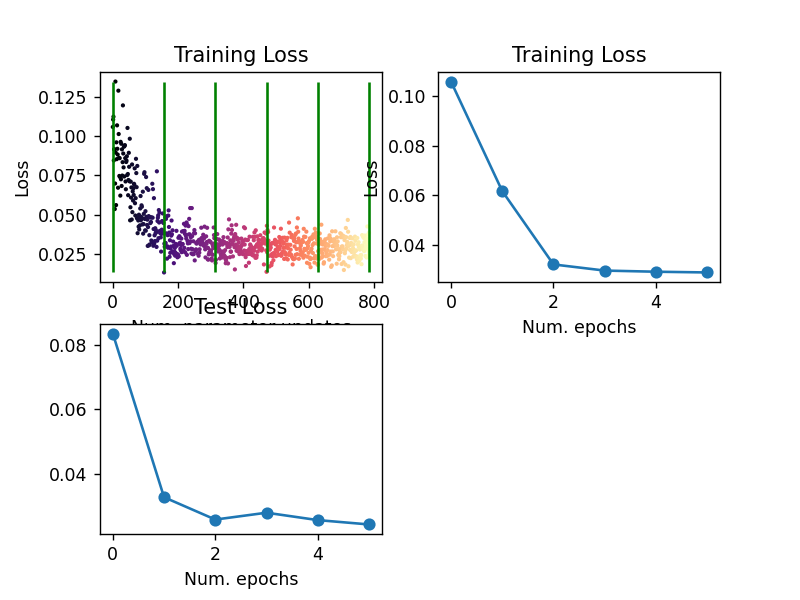

In [10]:
time = np.array([i for i in range(num_param_states)])

#plotting loss over training
plt.figure()
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.scatter(time, train_loss, c=cm.magma(time/(num_param_states-1)), s=2)
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
#plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')
plt.plot(ep_train_loss, 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

# plt.subplot(2, 2, 4)
# plt.title('Test Acc.')
# plt.xlabel('Num. epochs')
# plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [12]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 2) 
samples shape: (786, 2) 
transformed shape: (786, 2)
PCA explains [0.94816091 0.05183909] -> 99.99999999999999 % of variance


<IPython.core.display.Javascript object>


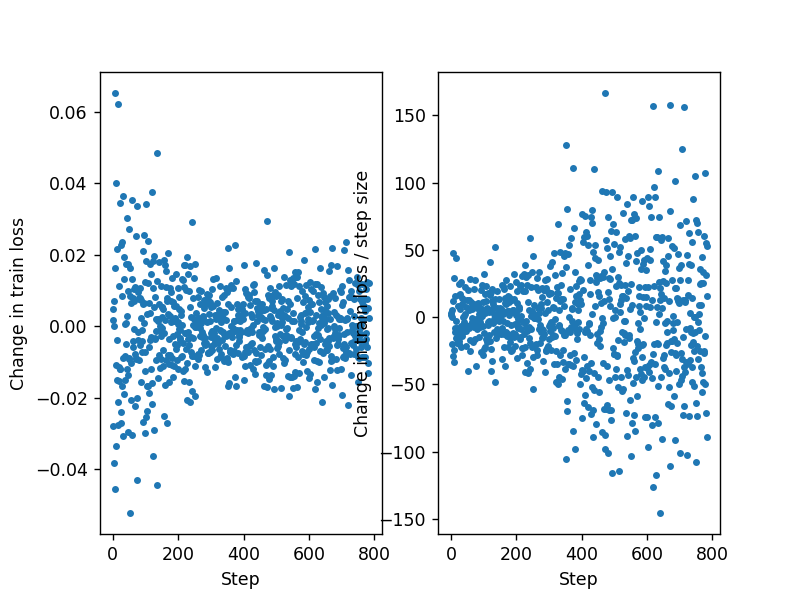

Text(0, 0.5, 'Change in train loss / step size')

In [13]:
#change in train loss per change in param (effective gradient)
change_train_loss = train_loss[1:] - train_loss[:-1]
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(change_train_loss, '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss")

plt.subplot(1, 2, 2)
plt.plot(change_train_loss/np.linalg.norm(steps, axis=-1), '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss / step size")

Distance travelled in parameter space: 0.2895822412474038


<IPython.core.display.Javascript object>


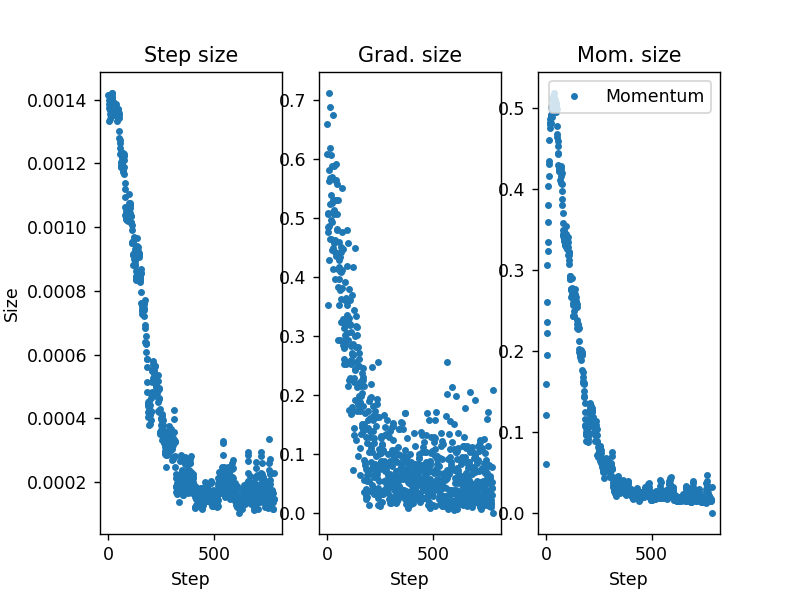

<IPython.core.display.Javascript object>


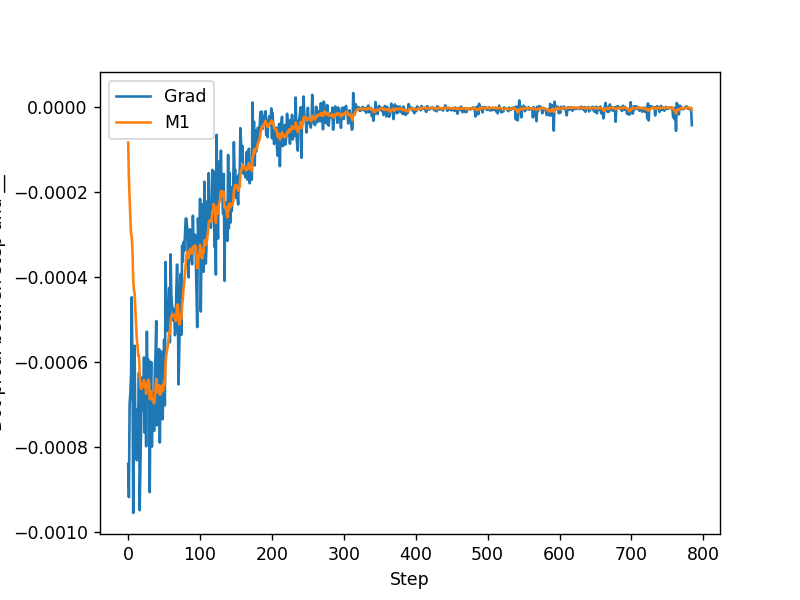

<IPython.core.display.Javascript object>


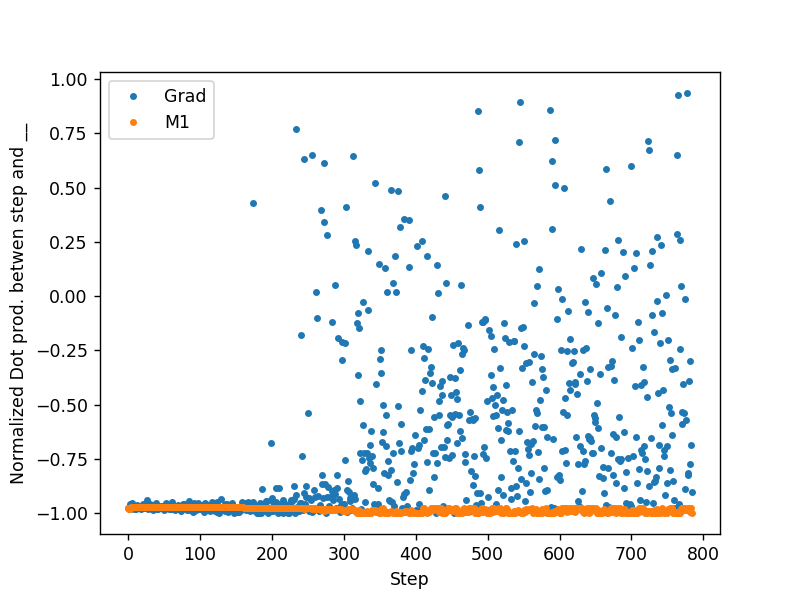

In [14]:
#Looking at properties of the steps the model took

#how far model has learned in param space
learning_length = np.linalg.norm(param_states[-1]-param_states[0])
print('Distance travelled in parameter space:', learning_length)

plt.figure()
plt.subplot(1, 3, 1)
plt.title("Step size")
plt.plot([i+1 for i in range(len(steps))], np.linalg.norm(steps, axis=-1), '.', label='Step')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 2)
plt.title("Grad. size")
plt.plot([i for i in range(len(grads))], np.linalg.norm(grads, axis=-1), '.', label='Grad')
#plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 3)
plt.title("Mom. size")
plt.plot([i for i in range(len(m1s))], np.linalg.norm(m1s, axis=-1), '.', label='Momentum')
#plt.ylabel('Size')
plt.xlabel("Step")
plt.legend()

plt.figure()
plt.ylabel('Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i]) for i in range(num_param_states-1)], label='Grad')
plt.plot([np.dot(steps[i], m1s[i]) for i in range(num_param_states-1)], label='M1')
plt.legend()

plt.figure()
plt.ylabel('Normalized Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i])/(np.linalg.norm(grads[i])*np.linalg.norm(steps[i])) for i in range(num_param_states-1)], '.', label='Grad')
plt.plot([np.dot(steps[i], m1s[i])/(np.linalg.norm(m1s[i])*np.linalg.norm(steps[i])) for i in range(num_param_states-1)], '.', label='M1')
plt.legend()

<IPython.core.display.Javascript object>


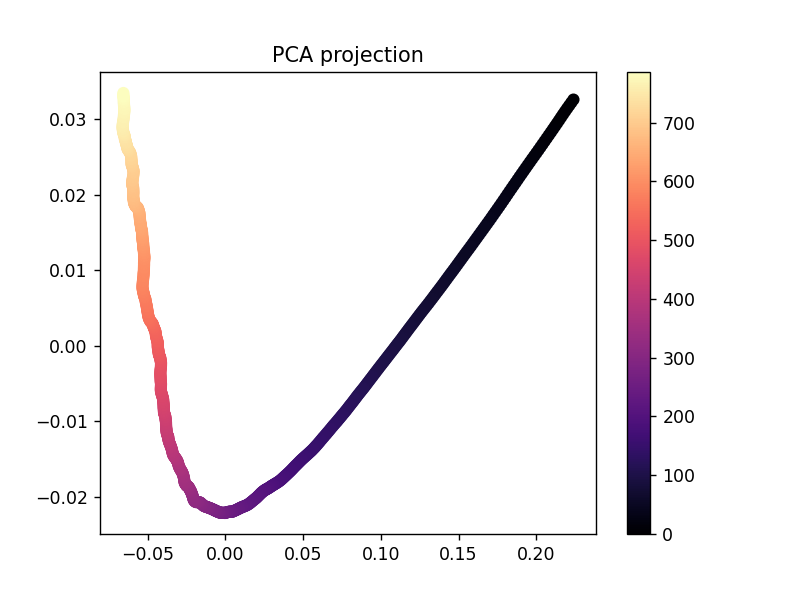

In [15]:
plt.figure()
plt.title('PCA projection')
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=[val for val in cmap(time/(num_param_states-1))])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))

In [16]:
#the two vectors from PCA, with shape (num_params)
pca_vec1 = pca.components_[0]
pca_vec2 = pca.components_[1]

pca_vec1_path = pca_embed[:, 0]
pca_vec2_path = pca_embed[:,1]

#setting initial model state to origin of PCA plot
orig_idx = 0
origin = param_states[orig_idx]
pca_vec1_path = pca_vec1_path - pca_vec1_path[orig_idx]*np.ones_like(pca_vec1_path)
pca_vec2_path = pca_vec2_path - pca_vec2_path[orig_idx]*np.ones_like(pca_vec2_path)

#applying PCA to gradients and m1s from Adam
pca.mean_ = np.zeros_like(pca.mean_)
grads_embed = pca.transform(grads)
m1s_embed = pca.transform(m1s)

<IPython.core.display.Javascript object>


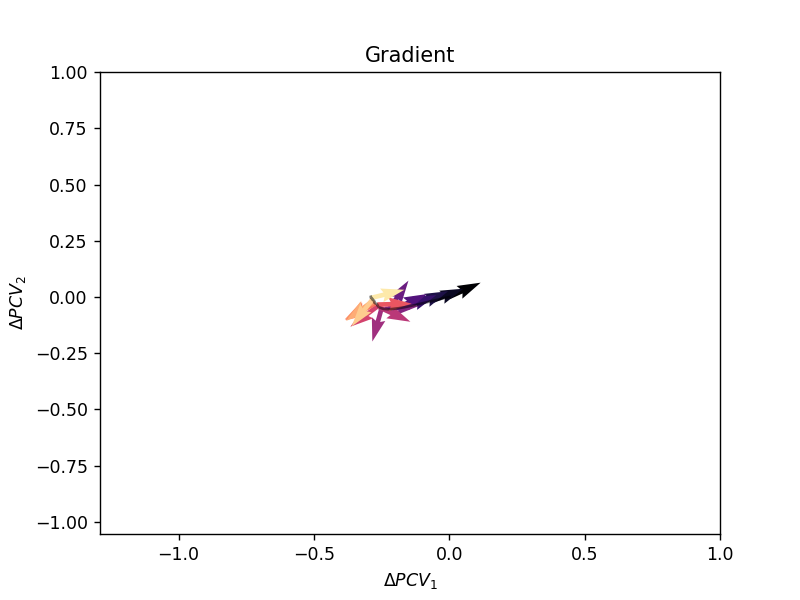

<IPython.core.display.Javascript object>


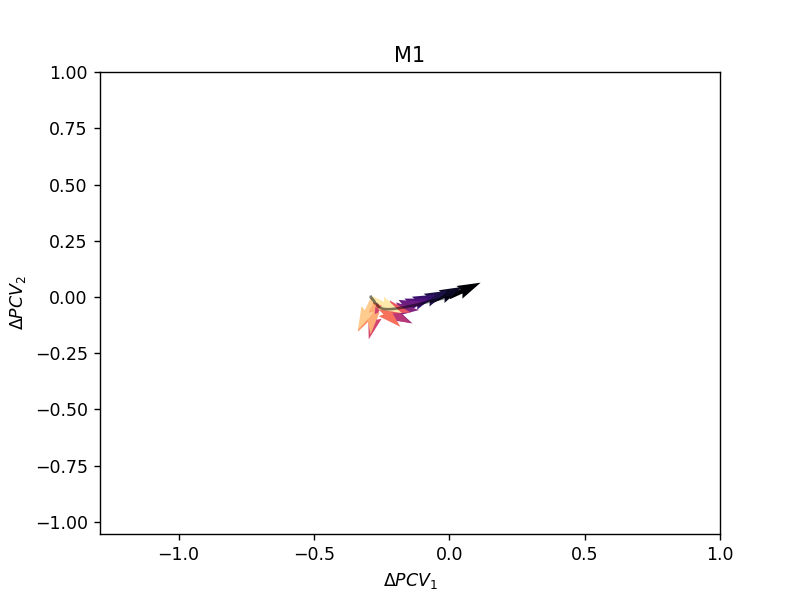

In [17]:
#can adjust pad to zoom in or out
pad = 1
resolution = 50

plt.figure()
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)

plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("Gradient")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], grads_embed[t,0], grads_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

plt.figure()
plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("M1")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], m1s_embed[t,0], m1s_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

In [18]:
#calculating loss landscape
from mpl_toolkits.mplot3d import Axes3D

def loss_at(param_state):
    state = vector_to_state_dict(param_state, model)

    model.load_state_dict(state)

    this_loss = test(train_data, model, loss_fn)
    return this_loss

def calc_loss_grid(lb1, ub1, lb2, ub2, origin=origin, v1_bins=20, v2_bins=20, filename=r'loss_grid'):
    #data in scatter form (m, b, Loss)
    #loss_grid = np.zeros((100, 100))
    info = np.array([lb1, ub1, lb2, ub2, v1_bins, v2_bins])

    range1 = np.linspace(lb1, ub1, v1_bins)
    range2 = np.linspace(lb2, ub2, v2_bins)

    pnts1 = np.zeros((range1.size*range2.size))
    pnts2 = np.zeros((range1.size*range2.size))
    loss_pnts = np.zeros((range1.size*range2.size))

    idx = 0
    for v1 in range1:
        for v2 in range2:
            if idx != 0 and idx % 10==0:
                print(idx, '/', len(loss_pnts))
            #print(idx, "/", len(b_pnts))
            pnts1[idx] = v1
            pnts2[idx] = v2
            #print(origin.shape, pca_vec1.shape, pca_vec2.shape)
            loss_pnts[idx] = loss_at(origin + v1*pca_vec1 + v2*pca_vec2)
            idx += 1

#     with open(filename + '.npz', 'wb') as file:
#         np.savez(file, info=info, v1_pnts=pnts1, v2_pnts=pnts2, loss_pnts=loss_pnts)
        
    return pnts1, pnts2, loss_pnts


minimum = min(list(pca_vec1_path) + list(pca_vec2_path))
maximum = max(list(pca_vec1_path) + list(pca_vec2_path))
pad = 1.2*(maximum-minimum)
lb1 = np.mean(pca_vec1_path) - pad
ub1 = np.mean(pca_vec1_path) + pad
lb2 = np.mean(pca_vec2_path) - pad
ub2 = np.mean(pca_vec2_path) + pad

v1_bins = 20
v2_bins = 20

v1_pnts, v2_pnts, loss_pnts = calc_loss_grid(lb1, ub1, lb2, ub2, v1_bins=v1_bins, v2_bins=v2_bins)

10 / 400
20 / 400
30 / 400
40 / 400
50 / 400
60 / 400
70 / 400
80 / 400
90 / 400
100 / 400
110 / 400
120 / 400
130 / 400
140 / 400
150 / 400
160 / 400
170 / 400
180 / 400
190 / 400
200 / 400
210 / 400
220 / 400
230 / 400
240 / 400
250 / 400
260 / 400
270 / 400
280 / 400
290 / 400
300 / 400
310 / 400
320 / 400
330 / 400
340 / 400
350 / 400
360 / 400
370 / 400
380 / 400
390 / 400


<IPython.core.display.Javascript object>


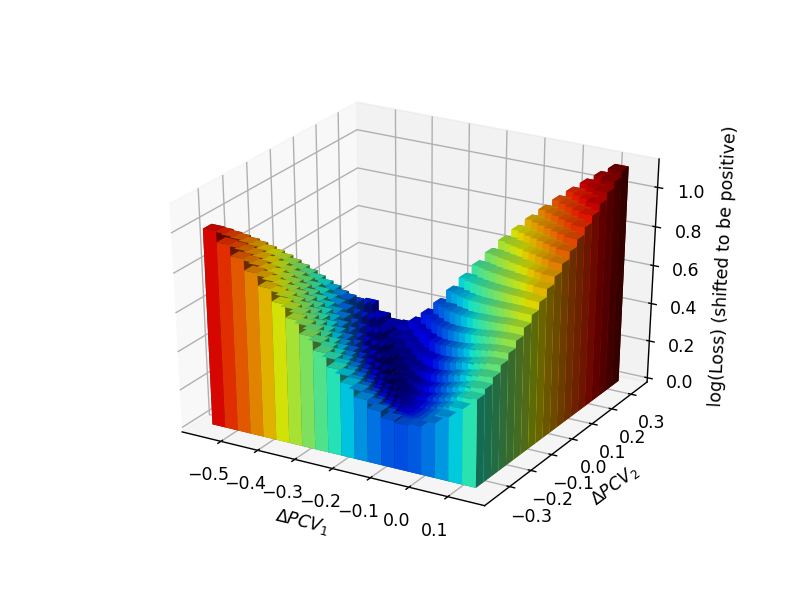

In [19]:
def bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, tuple):

    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(v2_pnts, v1_pnts, bins=tuple)
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

    #print(xpos)
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    #print(xpos)
    zpos = np.zeros_like(xpos)
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)
    #dz = loss_pnts

    #dz[np.argmin(dz)] = 10


    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/(max_height-min_height)) for k in dz]

    ax.bar3d(ypos, xpos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("Loss LEGO plot")
    plt.xlabel("$\Delta PCV_{1}$")
    plt.ylabel("$\Delta PCV_{2}$")
    #ax.set_zlabel('Loss')
    ax.set_zlabel('log(Loss) (shifted to be positive)')
    #ax.zaxis.set_scale('log')
    #plt.show()
    return

# with open('loss_grid.npz', 'rb') as f:
#     npzfile = np.load(f)
#     info = npzfile['info']
#     v1_pnts = npzfile['v1_pnts']
#     v2_pnts = npzfile['v2_pnts']
#     loss_pnts = npzfile['loss_pnts']
# lb1 = info[0]
# ub1 = info[1]
# lb2 = info[2]
# ub2 = info[3]
# v1_bins = int(info[4])
# v2_bins = int(info[5])

bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, (int(v1_bins),int(v2_bins)))

<IPython.core.display.Javascript object>


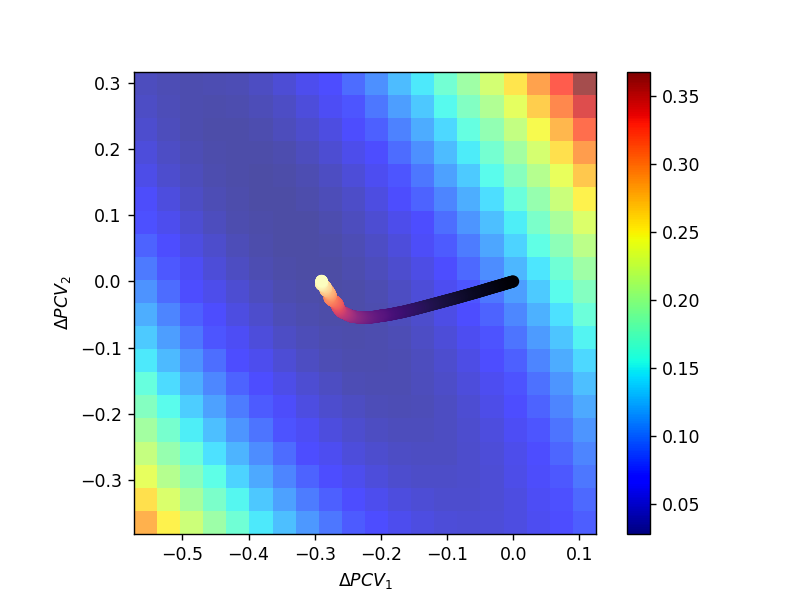

(-0.3817570572419117, 0.31662237503885166)

In [20]:
#log scaling if wanted
#loss_pnts = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)

low = min(loss_pnts)
high = max(loss_pnts)
#rescaling elements of loss_pnts
loss_pnts_scaled = (loss_pnts - low*np.ones_like(loss_pnts))/(high-low)

plt.figure()
cmap1 = cm.plasma
norm1 = colors.Normalize(vmin=min(loss_pnts), vmax=max(loss_pnts))
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet))
im_loss = loss_pnts.reshape(v1_bins,v2_bins)

cmap = cm.viridis
#norm1 = colors.Normalize(vmin=0, vmax=len(pca_vec1_path))

plt.imshow(np.flip(im_loss.T, axis=0), extent=[lb1,ub1,lb2,ub2], cmap=cm.jet, alpha=0.7)
plt.scatter(pca_vec1_path, pca_vec2_path, c=[cm.magma(i/len(pca_vec1_path)) for i in range(len(pca_vec1_path))], alpha=1, zorder=1)
#plt.scatter([250], [250], c=[(0,1,0)])
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
plt.xlim(lb1, ub1)
plt.ylim(lb2, ub2)